# Chapter 24

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

In [3]:
# import functions from modsim

from modsim import *

[Click here to run this chapter on Colab](https://colab.research.google.com/github/AllenDowney/ModSimPy/blob/master//chapters/chap24.ipynb)

In this chapter and the next we'll model systems that involve rotating objects.
In general, rotation is complicated.
In three dimensions, objects can rotate around three axes and many objects are easier to spin around some axes than others.

If the configuration of an object changes over time, it might become
easier or harder to spin, which explains the surprising dynamics of
gymnasts, divers, ice skaters, etc.

And when you apply a twisting force to a rotating object, the effect is often contrary to intuition. 
For an example, see this video on gyroscopic precession <http://modsimpy.com/precess>.

We will not take on the physics of rotation in all its glory; rather, we will focus on simple scenarios where all rotation and all twisting forces are around a single axis. 
In that case, we can treat some vector quantities as if they were scalars, in the same way that we sometimes treat velocity as a scalar with an implicit direction.

The fundamental ideas in these examples are angular velocity, angular acceleration, torque, and moment of inertia.
If you are not already familiar with these concepts, I will define them as we go along, and I will point to additional reading.

## The physics of toilet paper

As an example of a system with rotation, we'll simulate the manufacture of a roll of toilet paper, as shown in this video <https://youtu.be/Z74OfpUbeac?t=231>. 
Starting with a cardboard tube at the center, we will roll up 47 m of paper, a typical length for a roll of toilet paper in the U.S. (see <http://modsimpy.com/paper>).

The following figure shows a diagram of the system: $r$ represents
the radius of the roll at a point in time. Initially, $r$ is the radius of the cardboard core, $R_{min}$. When the roll is complete, $r$ is $R_{max}$.

![Diagram of a roll of toilet paper, showing change in paper length as a result of a small rotation, $d\theta$.](https://github.com/AllenDowney/ModSim/raw/main/figs/paper_roll.png)

I'll use $\theta$ to represent the total rotation of the roll in
radians. In the diagram, $d\theta$ represents a small increase in
$\theta$, which corresponds to a distance along the circumference of $r~d\theta$.

I'll use $y$ to represent the total length of paper that's been rolled. 
Initially, $\theta=0$ and $y=0$. 
For each small increase in $\theta$, there is a corresponding increase in $y$: 

$$dy = r~d\theta$$

If we divide both sides by a small increase in time, $dt$, we get a
differential equation for $y$ as a function of time.

$$\frac{dy}{dt} = r \frac{d\theta}{dt}$$ 

As we roll up the paper, $r$ increases. Assuming it increases by a fixed amount per revolution, we can write 

$$dr = k~d\theta$$ 

Where $k$ is an unknown constant we'll have to figure out. 
Again, we can divide both sides by $dt$ to get a differential equation in time:

$$\frac{dr}{dt} = k \frac{d\theta}{dt}$$ 

Finally, let's assume that $\theta$ increases at a constant rate of $\omega = 300$ rad/s (about 2900 revolutions per minute): 

$$\frac{d\theta}{dt} = \omega$$ 

This rate of change is called an **angular velocity**. Now we have a system of differential equations we can use to simulate the system.

## Parameters

Here are the parameters of the system:

In [4]:
Rmin = 0.02      # m
Rmax = 0.055     # m
L = 47           # m
omega = 300      # rad / s

`Rmin` and `Rmax` are the initial and final values for the radius, `r`.
`L` is the total length of the paper.
`omega` is the angular velocity in radians per second.

Figuring out `k` is not easy, but we can estimate it by pretending that `r` is constant and equal to the average of `Rmin` and `Rmax`:

In [5]:
Ravg = (Rmax + Rmin) / 2

In that case, the circumference of the roll is also be constant:

In [6]:
Cavg = 2 * np.pi * Ravg

And we can compute the number of revolutions to roll up length `L`, like this.

In [7]:
revs = L / Cavg

Converting rotations to radians, we can estimate the final value of `theta`.

In [8]:
theta = 2 * np.pi * revs
theta

1253.3333333333335

Finally, `k` is the total change in `r` divided by the total change in `theta`.

In [9]:
k_est = (Rmax - Rmin) / theta
k_est

2.7925531914893616e-05

At the end of the chapter, we'll derive `k` analytically, but this estimate is enough to get started.

## Simulation

The state variables we'll use are, `theta`, `y`, and `r`.
Here are the initial conditions:

In [10]:
init = State(theta=0, y=0, r=Rmin)

And here's a `System` object with `init` and `t_end`:

In [11]:
system = System(init=init, t_end=10)

Now we can use the differential equations from the previous section to
write a slope function:

In [12]:
def slope_func(t, state, system):
    theta, y, r = state
    
    dydt = r * omega
    drdt = k_est * omega
    
    return omega, dydt, drdt

As usual, the slope function takes a time stamp, a `State` object, and a `System` object. 

The job of the slope function is to compute the time derivatives of the state variables.

The derivative of `theta` is angular velocity, `omega`.
The derivatives of `y` and `r` are given by the differential equations we derived.

And as usual, we'll test the slope function with the initial conditions.

In [13]:
slope_func(0, system.init, system)

(300, 6.0, 0.008377659574468085)

We'd like to stop the simulation when the length of paper on the roll is `L`. We can do that with an event function that passes through 0 when `y` equals `L`:

In [14]:
def event_func(t, state, system):
    theta, y, r = state
    return L - y

We can test it with the initial conditions:

In [15]:
event_func(0, system.init, system)

47.0

Now let's run the simulation:

In [16]:
results, details = run_solve_ivp(system, slope_func,
                                  events=event_func)
details.message

'A termination event occurred.'

Here are the last few time steps.

In [17]:
results.tail()

,theta,y,r
4.010667,1203.200000,44.277760,0.05360
4.052444,1215.733333,44.951740,0.05395
4.094222,1228.266667,45.630107,0.05430
4.136000,1240.800000,46.312860,0.05465
4.177778,1253.333333,47.000000,0.05500


The time it takes to complete one roll is about 4.2 seconds, which is consistent with what we see in the video.

In [18]:
results.index[-1]

4.177777777777779

The final value of `y` is 47 meters, as expected.

In [19]:
final_state = results.iloc[-1] 
final_state.y

47.00000000000001

The final value of radius is 0.55 m, which is `Rmax`.

In [20]:
final_state.r

0.05500000000000001

The total number of rotations is close to 200, which seems plausible.

In [21]:
radians = final_state.theta
rotations = radians / 2 / np.pi
rotations

199.47419534184218

As an exercise, we'll see how fast the paper is moving.  But first, let's take a closer look at the results.

## Plotting

Here's what `theta` looks like over time.

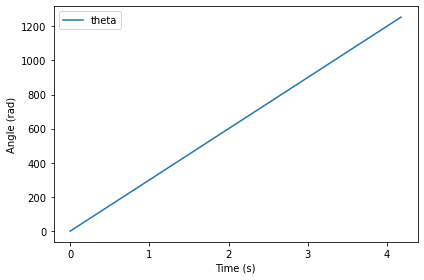

In [22]:
def plot_theta(results):
    results.theta.plot(color='C0', label='theta')
    decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')
    
plot_theta(results)

`theta` grows linearly, as we should expect with constant angular velocity.

Here's what `r` looks like over time.

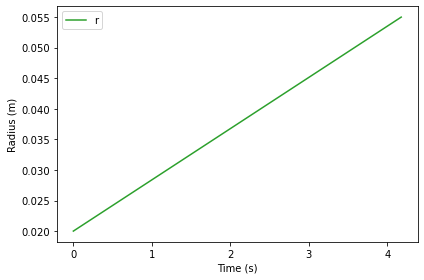

In [23]:
def plot_r(results):
    results.r.plot(color='C2', label='r')

    decorate(xlabel='Time (s)',
             ylabel='Radius (m)')
    
plot_r(results)

`r` also increases linearly.

But since the derivative of `y` depends on `r`, and `r` is increasing, `y` grows with increasing slope.

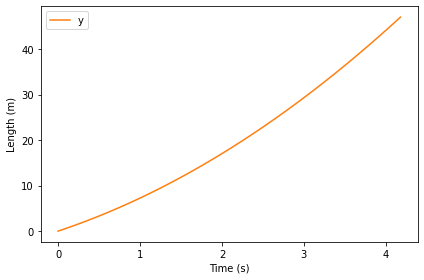

In [24]:
def plot_y(results):
    results.y.plot(color='C1', label='y')

    decorate(xlabel='Time (s)',
             ylabel='Length (m)')
    
plot_y(results)

In the next section, we'll see that we could have solved the
differential equations analytically.
However, it is often useful to start with simulation as a way of exploring and checking assumptions.

## Analysis

Since angular velocity is constant: 

$$\frac{d\theta}{dt} = \omega \quad\quad (1)$$ 

We can find $\theta$ as a function of time by integrating both sides:

$$\theta(t) = \omega t$$ 

Similarly, we can solve this equation

$$\frac{dr}{dt} = k \omega$$

to find

$$r(t) = k \omega t + R_{min}$$ 

Then we can plug the solution for $r$ into the equation for $y$: 

$$\begin{aligned}
\frac{dy}{dt} & = r \omega        \quad\quad (2)              \\
              & = \left[ k \omega t + R_{min} \right] \omega \nonumber\end{aligned}$$
              
Integrating both sides yields:

$$y(t) = \left[ k \omega t^2 / 2 + R_{min} t \right] \omega$$ 

So $y$ is a parabola, as you might have guessed.

We can also use these equations to find the relationship between $y$ and $r$, independent of time, which we can use to compute $k$.
Dividing Equations 1 and 2, yields

$$\frac{dr}{dy} = \frac{k}{r}$$ 

Separating variables yields

$$r~dr = k~dy$$ 

Integrating both sides yields 

$$r^2 / 2 = k y + C$$ 

Solving for $y$, we have 

$$y = \frac{1}{2k} (r^2 - C)                 \label{eqn3}$$

When $y=0$, $r=R_{min}$, so 

$$R_{min}^2 / 2 = C$$ 

When $y=L$, $r=R_{max}$, so

$$L = \frac{1}{2k} (R_{max}^2 - R_{min}^2)$$ 

Solving for $k$ yields

$$k =  \frac{1}{2L} (R_{max}^2 - R_{min}^2)           \label{eqn4}$$

Plugging in the values of the parameters yields `2.8e-5` m/rad, the same as the "estimate" we computed in Section xxx. 

In [25]:
k = (Rmax**2 - Rmin**2) / (2 * L)
k

2.7925531914893616e-05

In this case the estimate turns out to be exact.

## Summary

This chapter introduces rotation, starting with an example where angular velocity is constant.

We simulated the manufacture of a roll of toilet paper, then we solved the same problem analytically.

In the next chapter, we'll see a more interesting example where angular velocity is not constant.  And we'll introduce three new concepts: torque, angular acceleration, and moment of inertia.

But first, you might want to work on the following exercise.

## Exercises

**Exercise:** Since we keep `omega` constant, the linear velocity of the paper increases with radius.  We can use `gradient` to estimate the derivative of `results.y`.

In [26]:
dydt = gradient(results.y)

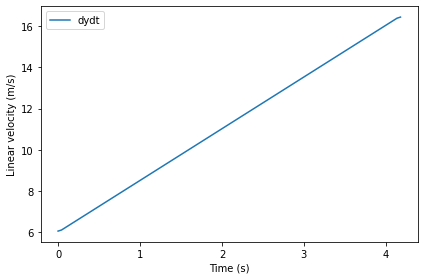

In [27]:
dydt.plot(label='dydt')
decorate(xlabel='Time (s)',
         ylabel='Linear velocity (m/s)')

With constant angular velocity, linear velocity is increasing, reaching its maximum at the end.

In [28]:
max_linear_velocity = dydt.iloc[-1]
max_linear_velocity

16.447499999999934

Now suppose this peak velocity is the limiting factor; that is, we can't move the paper any faster than that.

In that case, we might be able to speed up the process by keeping the linear velocity at the maximum all the time.

Write a slope function that keeps the linear velocity, `dydt`, constant, and computes the angular velocity, `omega`, accordingly.

Run the simulation and see how much faster we could finish rolling the paper.

In [29]:
# Solution

def slope_func(t, state, system):
    theta, y, r = state
    
    dydt = max_linear_velocity
    omega = dydt / r
    drdt = k * omega
    
    return omega, dydt, drdt

In [30]:
# Solution

slope_func(0, system.init, system)

(822.3749999999967, 16.447499999999934, 0.022965259308510545)

In [31]:
# Solution

results, details = run_solve_ivp(system, slope_func, 
                                 events=event_func)
details.message

'A termination event occurred.'

In [32]:
# Solution

t_final = results.index[-1]
t_final

2.8575771393828964

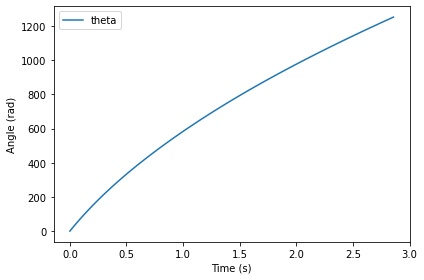

In [33]:
# Solution

plot_theta(results)

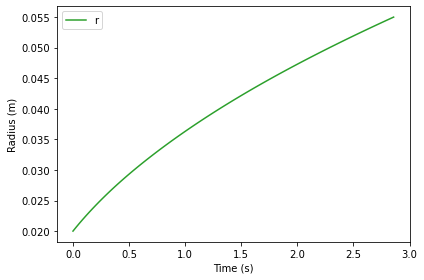

In [34]:
# Solution

plot_r(results)

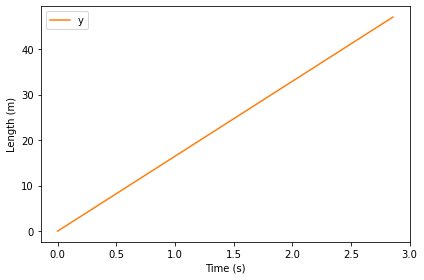

In [35]:
# Solution

plot_y(results)